<a href="http://www.persistent-identifier.nl/?identifier=urn%3Anbn%3Anl%3Aui%3A13-048i-71" target="_blank"><img align="left"src="images/etcbc4easy-small.png"/></a>
<a href="http://laf-fabric.readthedocs.org/en/latest/" target="_blank"><img align="left" src="images/laf-fabric-xsmall.png"/></a>
<a href="http://www.godgeleerdheid.vu.nl/etcbc" target="_blank"><img align="right" src="images/VU-ETCBC-xsmall.png"/></a>

# Kings and parallels

Joint work of Martijn Naaijer and Dirk Roorda.

This is a case study to 2 Kings 19-25 and passages that run partly parallel to these chapters.
These variants occur in Chronicles, Isaiah and Jeremiah.

We find the variants by using the database of cross references made by the 
[cross ref tool in SHEBANQ](https://shebanq.ancient-data.org/tools?goto=parallel).

## Results

* Graph of parallels. See below or [download as pdf](kings_parallels.pdf).
* Synoptic view of the main portions. 
  In [Hebrew](kings_parallels_h.html) or [phonetic](kings_parallels_p.html).
* Chapter diffs of the relevant chapters in Jesaia, between the Masoretic text and the Qumran text.
  [Jesaia 37](jesaia-mt-1q_37.html)
  [Jesaia 38](jesaia-mt-1q_38.html)
  [Jesaia 39](jesaia-mt-1q_39.html).

In [14]:
import sys,os, re, pickle
import collections, difflib
from IPython.display import HTML, display_pretty, display_html
from difflib import SequenceMatcher
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

import laf
from laf.fabric import LafFabric
from etcbc.preprocess import prepare
from etcbc.lib import Transcription
fabric = LafFabric()

  0.00s This is LAF-Fabric 4.5.12
API reference: http://laf-fabric.readthedocs.org/en/latest/texts/API-reference.html
Feature doc: https://shebanq.ancient-data.org/static/docs/featuredoc/texts/welcome.html



In [15]:
source = 'etcbc'
version = '4b'

In [16]:
API = fabric.load(source+version, 'lexicon', 'kings', {
    "xmlids": {"node": False, "edge": False},
    "features": ('''
        otype
        language lex lex_utf8 g_cons_utf8 g_word_utf8 trailer_utf8 phono phono_sep
        book chapter verse label number
    ''',''),
    "prepare": prepare,
    "primary": False,
}, verbose='NORMAL')
exec(fabric.localnames.format(var='fabric'))

  0.00s LOADING API: please wait ... 
  0.00s USING main  DATA COMPILED AT: 2015-11-02T15-08-56
  0.00s USING annox DATA COMPILED AT: 2016-01-27T19-01-17
  5.48s LOGFILE=/Users/dirk/SURFdrive/laf-fabric-output/etcbc4b/kings/__log__kings.txt
  5.48s INFO: LOADING PREPARED data: please wait ... 
  5.49s prep prep: G.node_sort
  5.61s prep prep: G.node_sort_inv
  6.27s prep prep: L.node_up
    11s prep prep: L.node_down
45m 49s END
    19s prep prep: V.verses
    19s ETCBC reference: http://laf-fabric.readthedocs.org/en/latest/texts/ETCBC-reference.html
    21s INFO: LOADED PREPARED data
    21s INFO: DATA LOADED FROM SOURCE etcbc4b AND ANNOX lexicon FOR TASK kings AT 2016-02-22T18-30-14


Config information.

In [124]:
REFBOOKS = {'Reges_II'}
REFCHAPTERS = set(range(19,26))

Q1_FILE = 'qisaa_an.txt'
SHEBANQ_PATH = os.path.abspath('{}/../../../shebanq'.format(os.getcwd))
#CROSSREF_DB = '{}/static/docs/tools/parallel/files/crossrefs_lcs_db.txt'.format(SHEBANQ_PATH)
CROSSREF_DB = '{}/static/docs/tools/parallel/files/crossrefdb.csv'.format(SHEBANQ_PATH)
#PASSAGE_FMT = '{}.{}.{}'
PASSAGE_FMT = '{}~{}:{}'

SIM_THRESHOLD = 79 # the smallest value that causes Leviticus to be left out

NCOL_FILE = 'these_crossrefs.ncol'
ALL_VERSES_FILE = 'all_verses.txt'
NEW_MATRIX_FILE = 'new_matrix.tsv'

In [125]:
book_node = dict()
for b in F.otype.s('book'):
    book_name = F.book.v(b)
    book_node[book_name] = b
    if book_name == 'Reges_II':
        book_node[book_name+'r'] = b

Read the qumran scroll 1Q

In [126]:
trans_final_pat = re.compile('([KMNPY])(?= |\Z)')

def trans_final_repl(match): return match.group(1).lower()

msg('reading Q1')
qf = open(Q1_FILE)
q1 = collections.defaultdict(lambda: collections.defaultdict(lambda: []))
nwords = 0
for line in qf:
    nwords += 1
    (passage, word, xword) = line.strip().split()
    (chapter, verse) = passage.split(',')
    word = trans_final_pat.sub(trans_final_repl, word)
    q1[int(chapter)][int(verse)].append(Transcription.to_hebrew_x(word))
qf.close()
msg('{} words in {} chapters in {} verses'.format(nwords, len(q1), sum(len(q1[x]) for x in q1)))

 3h 00m 24s reading Q1
 3h 00m 24s 16862 words in 66 chapters in 1290 verses


In [127]:
print(' '.join(q1[1][1]))

חזון ישׁעיהו בן אמוץ אשׁר חזה על יהודה וירושׁלם ביומי עוזיה יותם אחז יחזקיה מלכי יהודה


Read the crossrefs database file and distill the parallels with the reference chapters: 2 Kings 19-25.

The next cell will produce an edge list in NCOL_FILE, ready to be imported by networkx.

Furthermore, the similarities will be stored in ``cliques``, which is a dictionary keyed by references to verses in the reference chapters. The values are the sets of references of parallel verses to the key verse.

We also build sets of all books, chapters and verses that are involved in the filtered similarities.

In [132]:
cliques = collections.defaultdict(lambda: set())
msg('Reading crossrefs database and picking out the relevant ones')
n = 0
all_verses = set()
new_sim_matrix = {}
ncoldata = []
with open(CROSSREF_DB) as f:
    for line in f:
        n += 1
        if n == 1: continue
        (bkx, chx, vsx, bky, chy, vsy, rd) = line.rstrip('\n').split('\t')
        if int(rd) < SIM_THRESHOLD: continue
        (chx, vsx, chy, vsy) = (int(z) for z in (chx, vsx, chy, vsy))
        if bkx in REFBOOKS and chx in REFCHAPTERS: cliques[(bkx, chx, vsx)].add((bky, chy, vsy))
        if bky in REFBOOKS and chy in REFCHAPTERS: cliques[(bky, chy, vsy)].add((bkx, chx, vsx))
        if (bkx in REFBOOKS and chx in REFCHAPTERS) or bky in REFBOOKS and chy in REFCHAPTERS:
            if bkx in REFBOOKS and chx in REFCHAPTERS: bkx += 'r'
            if bky in REFBOOKS and chy in REFCHAPTERS: bky += 'r'
            all_verses.add((bkx, chx, vsx))
            all_verses.add((bky, chy, vsy))
            if bkx == 'Reges_IIr':
                new_sim_matrix.setdefault(PASSAGE_FMT.format(bkx, chx, vsx), {})[PASSAGE_FMT.format(bky, chy, vsy)] = int(rd)
                ncoldata.append(((bkx, chx, vsx), (bky, chy, vsy), rd))
            else:
                new_sim_matrix.setdefault(PASSAGE_FMT.format(bky, chy, vsy), {})[PASSAGE_FMT.format(bkx, chx, vsx)] = int(rd)
                ncoldata.append(((bky, chy, vsy), (bkx, chx, vsx), rd))
all_verses_srt = sorted(all_verses, key=lambda x: (book_node[x[0]], x[1], x[2]))
    
ncolfile = open(NCOL_FILE, 'w')
for (x, y, r) in sorted(ncoldata, key=lambda z: (
        book_node[z[0][0]], z[0][1], z[0][2], 
        book_node[z[1][0]], z[1][1], z[1][2],
)):
    ncolfile.write('{} {} {}\n'.format(PASSAGE_FMT.format(*x), PASSAGE_FMT.format(*y), r))
ncolfile.close()
    
msg('{} entries read'.format(n))
countrefs = collections.Counter()
for x in cliques: countrefs[len(cliques[x])+1] += 1
for x in sorted(countrefs): msg('Cliques of length {}: {}'.format(x, countrefs[x]))
all_books = {x[0] for x in all_verses}
all_chapters = {(x[0], x[1]) for x in all_verses}
msg('{}, {}, {} relevant verses, chapters, books'.format(len(all_verses), len(all_chapters), len(all_books)))
print(' '.join(sorted(all_books)))

mfile = open(NEW_MATRIX_FILE, 'w')
headrow = '\t'.join(PASSAGE_FMT.format(*x) for x in all_verses_srt)
mfile.write('passage\t{}\n'.format(headrow))
for x in all_verses_srt:
    row = '\t'.join(str(new_sim_matrix.get(PASSAGE_FMT.format(*x), {}).get(PASSAGE_FMT.format(*y), 0)) for y in all_verses_srt)
    mfile.write('{}\t{}\n'.format(PASSAGE_FMT.format(*x), row))
mfile.close()

 3h 02m 21s Reading crossrefs database and picking out the relevant ones
 3h 02m 21s 14354 entries read
 3h 02m 21s Cliques of length 2: 91
 3h 02m 21s Cliques of length 3: 1
 3h 02m 21s Cliques of length 4: 1
 3h 02m 21s Cliques of length 5: 1
 3h 02m 21s Cliques of length 8: 3
 3h 02m 21s Cliques of length 11: 3
 3h 02m 21s 204, 24, 7 relevant verses, chapters, books


Chronica_II Haggai Jeremia Jesaia Reges_I Reges_II Reges_IIr


In [133]:
allvfile = open(ALL_VERSES_FILE, 'w')
for p in sorted(all_verses, key=lambda x: (book_node[x[0]], x[1], x[2])):
    allvfile.write('{}~{}:{}\n'.format(*p))
allvfile.close()

We now visualize the similarities in a graph, using networkx.
We firmly determine the layout, not following any of the methods provided by networkx.

We put the verses into columns by the book they occurr in.
We order the rows of verses according to their order in the text.

Finally, we shift rows of verses up and down in order to aline them with their parallel stretches.

We add a virtual book, ``Reges_IIr`` which is the book Reges_II restricted to the reference chapters. ``Reges_II`` stands for the other chapters of 2 Kings.

In [134]:
g = nx.read_weighted_edgelist(NCOL_FILE)

Compute the colors and the offsets of the nodes.

In [137]:
gcolors = dict(
    Haggai=(0.7, 0.7, 0.7),
    Reges_IIr=(0.9, 0.9, 0.9),
    Reges_II=(1.0, 1.0, 0.3),
    Reges_I=(0.3, 0.3, 1.0),
    Chronica_II=(1.0, 0.3, 1.0),
    Jeremia=(0.3, 1.0, 0.3),
    Jesaia=(1.0, 0.3, 0.3),
)

all_books_cust = '''
    Haggai Jeremia Jesaia Reges_I Reges_II Reges_IIr Chronica_II
'''.strip().split()

offset_y = dict(
    Haggai=55,
    Reges_IIr=0,
    Reges_II=65,
    Reges_I=65,
    Chronica_II=50,
    Jeremia=70,
    Jesaia=0,
    Leviticus=0,
    Genesis=0,
)

ncolors = [gcolors[x.split('~')[0]] for x in g.nodes()]
nlabels = dict((x, x.split('~')[1]) for x in g.nodes())
ncols = len(all_books)
pos_x = dict((x, i) for (i,x) in enumerate(all_books_cust))
verse_lists = collections.defaultdict(lambda: [])
for (bk, ch, vs) in sorted(all_verses):
    verse_lists[bk].append('{}:{}'.format(ch, vs))
nrows = max(len(verse_lists[bk]) for bk in all_books_cust)
pos = {}
for bk in verse_lists:
    for (i, chvs) in enumerate(verse_lists[bk]):
        pos['{}~{}'.format(bk, chvs)] = (pos_x[bk], i+offset_y[bk])

Now do the actual plotting.

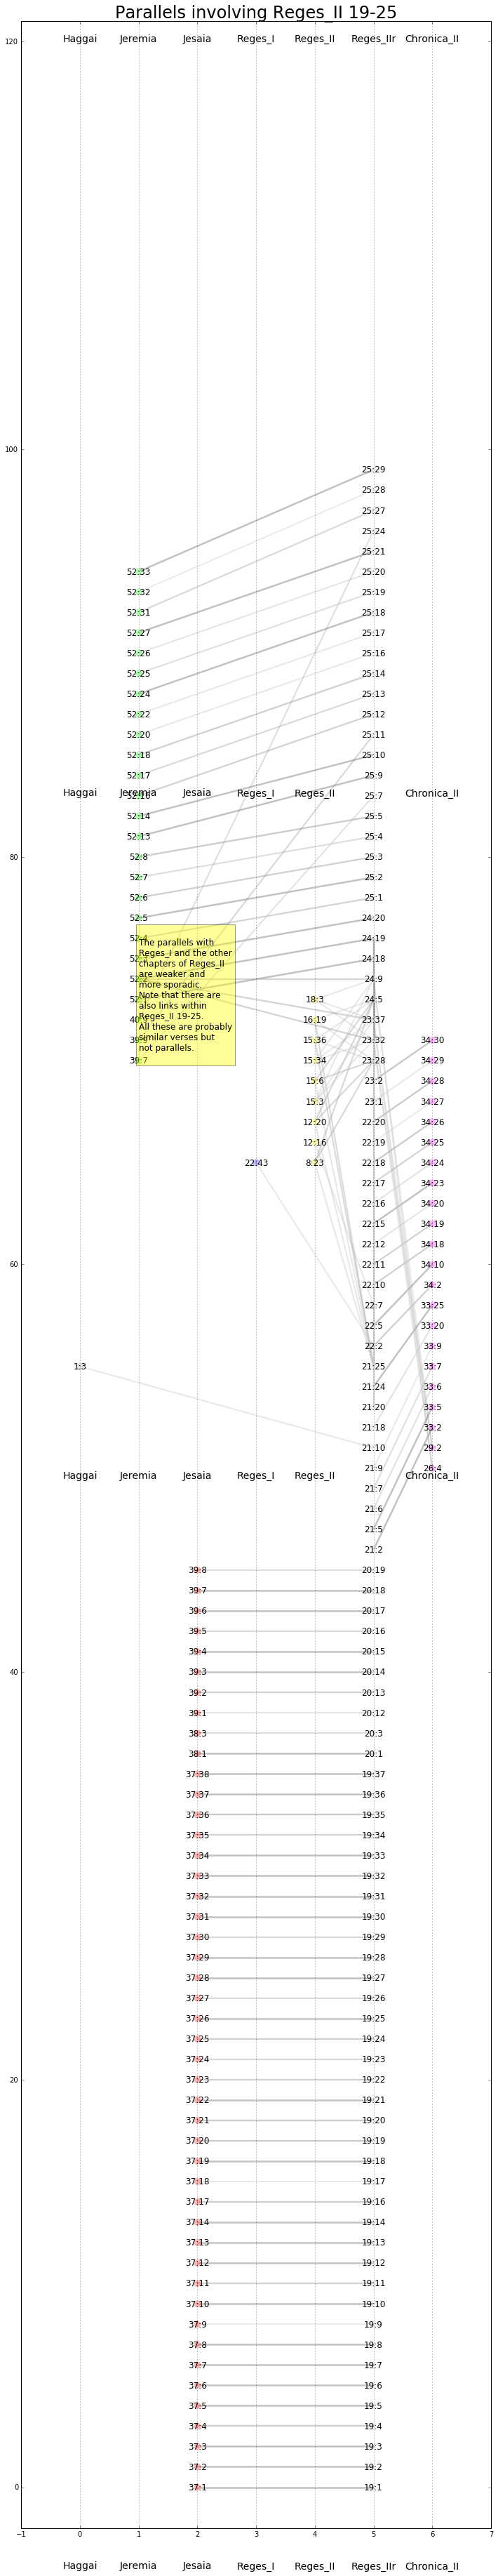

In [138]:
plt.figure(figsize=(12,64))

nx.draw_networkx(g, pos,
    width=[g.get_edge_data(*x)['weight']/40 for x in g.edges()],
    edge_color=[g.get_edge_data(*x)['weight']/1.2 for x in g.edges()],
    edge_cmap=plt.cm.Greys,
    edge_vmin=50,
    edge_vmax=100,
    node_color=ncolors,
    node_size=100,
    labels=nlabels,
    alpha=0.4,
    linewidths=0,
)
#plt.axis('tight')
plt.ylim(-2, 121)
book_font_size = 14
plt.grid(b=True, which='both', axis='x')
plt.title('Parallels involving Reges_II 19-25', fontsize=24)
plt.text(1,70, '''
The parallels with
Reges_I and the other
chapters of Reges_II
are weaker and 
more sporadic.
Note that there are
also links within
Reges_II 19-25.
All these are probably
similar verses but
not parallels.
''', #bbox=dict(width=145, height=200, facecolor='yellow', alpha=0.4), fontsize=12)
     # suddenly the width and height keyword args are no longer accepted.
     # bbox performs an auto fit
     bbox=dict(facecolor='yellow', alpha=0.4), fontsize=12)
for bk in all_books_cust:
    for (ypos, suppress) in ((-4, False), (49.5, True), (83, True), (120, False)):
        if not suppress or bk != 'Reges_IIr':
            plt.text(pos_x[bk], ypos, bk, fontsize=book_font_size, horizontalalignment='center')

plt.savefig('kings_parallels.pdf')

From the graph above we read off which are the interesting passages to compare:

Reges_II 19-20:19 with Jesaia 37-39:8

Reges_II 21-23:3 with Chronica_II 33-34:31

Reges_II 23:31-25:30 with Jeremia 52-52:34

In [17]:
corresp_spec = (
    (('Reges_II', (19, 1), (20,19)), ('Jesaia',      (37, 1), (39, 8))),
    (('Reges_II', (21, 1), (23, 3)), ('Chronica_II', (33, 1), (34,31))),
    (('Reges_II', (23,31), (25,30)), ('Jeremia',     (52, 1), (52,34))),
)

# Verse index

We make an index of verses.

``passage2vnode`` maps a verse label ``(book, chapter, verse)`` into the corresponding verse node.

``verses`` is a structure that reflects the complete section structure.
It is a dictionary keyed by book names, and then by chapter numbers, storing lists of verse numbers.

In [18]:
msg("Making a mapping between a passage specification and a verse node")
# we also make a list of all verses in all reference chapters
verses = collections.defaultdict(lambda: collections.defaultdict(lambda: []))
passage2vnode = {}
for vn in F.otype.s('verse'):
    bk = F.book.v(vn)
    ch = int(F.chapter.v(vn))
    vs = int(F.verse.v(vn))
    lab = (bk, ch, vs)
    passage2vnode[lab] = vn
    verses[bk][ch].append(vs)
msg("{} verses".format(len(passage2vnode)))

15m 18s Making a mapping between a passage specification and a verse node
15m 19s 23213 verses


We have three meaningful comparisons to make.
For every comparison, we are going to split the material into *reference* verses, i.e. the verses from 2 Kings, and *parallel* verses, i.e. the verses in the other books that are parallel with it.

As an auxiliary function, we need something that gives us a list of all verses in a book from a given start position to a given and position, where these positions are given as chapter number - verse number pairs.

In [19]:
def get_verselist(bk, start, end):
    (start_ch, start_vs) = start
    (end_ch, end_vs) = end
    result_list = []
    for ch in range(start_ch, end_ch+1):
        lower_vs = start_vs if ch == start_ch else 1
        upper_vs = end_vs if ch == end_ch else verses[bk][ch][-1]
        for vs in range(lower_vs, upper_vs+1):
            result_list.append((bk, ch, vs))
    return tuple(result_list)

In a sequence of steps we are going to construct a list of verse pairs that have to be compared side by side. We order the lists by the occurrences in the reference verses.
We need to insert missing verses into the reference list and parallel list.

First step: for each passage, compose the reference list and the parallel list, without filling any gaps.

The result is ``compare_passages_proto``.

On the fly we construct the set of all reference verses and of all parallel verses.

In [20]:
compare_passages_proto = []
refverses = set()
parverses = set()
for (ref, par) in corresp_spec:
    reflist = get_verselist(*ref)
    parlist = get_verselist(*par)
    refverses |= set(reflist)
    parverses |= set(parlist)
    compare_passages_proto.append((
        reflist,
        parlist,
    ))

In [21]:
compare_passages_proto[0]

((('Reges_II', 19, 1),
  ('Reges_II', 19, 2),
  ('Reges_II', 19, 3),
  ('Reges_II', 19, 4),
  ('Reges_II', 19, 5),
  ('Reges_II', 19, 6),
  ('Reges_II', 19, 7),
  ('Reges_II', 19, 8),
  ('Reges_II', 19, 9),
  ('Reges_II', 19, 10),
  ('Reges_II', 19, 11),
  ('Reges_II', 19, 12),
  ('Reges_II', 19, 13),
  ('Reges_II', 19, 14),
  ('Reges_II', 19, 15),
  ('Reges_II', 19, 16),
  ('Reges_II', 19, 17),
  ('Reges_II', 19, 18),
  ('Reges_II', 19, 19),
  ('Reges_II', 19, 20),
  ('Reges_II', 19, 21),
  ('Reges_II', 19, 22),
  ('Reges_II', 19, 23),
  ('Reges_II', 19, 24),
  ('Reges_II', 19, 25),
  ('Reges_II', 19, 26),
  ('Reges_II', 19, 27),
  ('Reges_II', 19, 28),
  ('Reges_II', 19, 29),
  ('Reges_II', 19, 30),
  ('Reges_II', 19, 31),
  ('Reges_II', 19, 32),
  ('Reges_II', 19, 33),
  ('Reges_II', 19, 34),
  ('Reges_II', 19, 35),
  ('Reges_II', 19, 36),
  ('Reges_II', 19, 37),
  ('Reges_II', 20, 1),
  ('Reges_II', 20, 2),
  ('Reges_II', 20, 3),
  ('Reges_II', 20, 4),
  ('Reges_II', 20, 5),
  ('Re

We need a restricted version of our clique information: we are only interested in the parallels between verses that are either reference verses of its parallels. Here we are constructing a thinned version of our clique dictionary. For this we need the sets of reference verses and parallel version that we constructed in the previous step.

In [22]:
cliques_reduced = collections.defaultdict(lambda: set())
for ref in set(cliques.keys()) & refverses:
    pars = cliques[ref] & parverses
    cliques_reduced[ref] = pars
    for par in pars: cliques_reduced[par].add(ref)

Now we are going to enrich the verses with the particular verses they need to be compared with.
Every entry will contain the verse references and a list of its similar verses.
We do this for both the reference lists and the parallel lists, although this is a bit redundant. We want to keep the symmetry for as long as possible.
The result is ``compare_passages_multi``.

In [23]:
compare_passages_multi = []
for (ref, par) in compare_passages_proto:
    compare_passages_multi.append((
        tuple((x, cliques_reduced[x]) for x in ref),
        tuple((x, cliques_reduced[x]) for x in par),
    ))

In [24]:
compare_passages_multi[0]

(((('Reges_II', 19, 1), {('Jesaia', 37, 1)}),
  (('Reges_II', 19, 2), {('Jesaia', 37, 2)}),
  (('Reges_II', 19, 3), {('Jesaia', 37, 3)}),
  (('Reges_II', 19, 4), {('Jesaia', 37, 4)}),
  (('Reges_II', 19, 5), {('Jesaia', 37, 5)}),
  (('Reges_II', 19, 6), {('Jesaia', 37, 6)}),
  (('Reges_II', 19, 7), {('Jesaia', 37, 7)}),
  (('Reges_II', 19, 8), {('Jesaia', 37, 8)}),
  (('Reges_II', 19, 9), {('Jesaia', 37, 9)}),
  (('Reges_II', 19, 10), {('Jesaia', 37, 10)}),
  (('Reges_II', 19, 11), {('Jesaia', 37, 11)}),
  (('Reges_II', 19, 12), {('Jesaia', 37, 12)}),
  (('Reges_II', 19, 13), {('Jesaia', 37, 13)}),
  (('Reges_II', 19, 14), {('Jesaia', 37, 14)}),
  (('Reges_II', 19, 15), {('Jesaia', 37, 16)}),
  (('Reges_II', 19, 16), {('Jesaia', 37, 17)}),
  (('Reges_II', 19, 17), {('Jesaia', 37, 18)}),
  (('Reges_II', 19, 18), {('Jesaia', 37, 19)}),
  (('Reges_II', 19, 19), {('Jesaia', 37, 20)}),
  (('Reges_II', 19, 20), {('Jesaia', 37, 21)}),
  (('Reges_II', 19, 21), {('Jesaia', 37, 22)}),
  (('Reges

The next step is to replace the cases where a verse is associated with more than one verse to be compared with, with sequences of binary comparisons. So if ``(r1, {v1, v2})`` occurs in ``compare_passages_multi``, we replace it by two entries ``(r1, v1)`` and ``(r1, v2)``.
There are cases where a verse does not have any similar one. There we insert a comparison with a null verse (``no_verse``). The result is ``compare_verses``.

In [25]:
no_verse = ('', 0, 0)

def singlify(vmulti):
    vsingle = []
    for (x, xset) in vmulti:
        if len(xset) == 0:
            vsingle.append((x, no_verse))
        else:
            for y in sorted(xset):
                vsingle.append((x, y))
    return tuple(vsingle)

compare_passages = []
for (ref, par) in compare_passages_multi:
    compare_passages.append((singlify(ref), singlify(par)))

In [26]:
compare_passages[0]

(((('Reges_II', 19, 1), ('Jesaia', 37, 1)),
  (('Reges_II', 19, 2), ('Jesaia', 37, 2)),
  (('Reges_II', 19, 3), ('Jesaia', 37, 3)),
  (('Reges_II', 19, 4), ('Jesaia', 37, 4)),
  (('Reges_II', 19, 5), ('Jesaia', 37, 5)),
  (('Reges_II', 19, 6), ('Jesaia', 37, 6)),
  (('Reges_II', 19, 7), ('Jesaia', 37, 7)),
  (('Reges_II', 19, 8), ('Jesaia', 37, 8)),
  (('Reges_II', 19, 9), ('Jesaia', 37, 9)),
  (('Reges_II', 19, 10), ('Jesaia', 37, 10)),
  (('Reges_II', 19, 11), ('Jesaia', 37, 11)),
  (('Reges_II', 19, 12), ('Jesaia', 37, 12)),
  (('Reges_II', 19, 13), ('Jesaia', 37, 13)),
  (('Reges_II', 19, 14), ('Jesaia', 37, 14)),
  (('Reges_II', 19, 15), ('Jesaia', 37, 16)),
  (('Reges_II', 19, 16), ('Jesaia', 37, 17)),
  (('Reges_II', 19, 17), ('Jesaia', 37, 18)),
  (('Reges_II', 19, 18), ('Jesaia', 37, 19)),
  (('Reges_II', 19, 19), ('Jesaia', 37, 20)),
  (('Reges_II', 19, 20), ('Jesaia', 37, 21)),
  (('Reges_II', 19, 21), ('Jesaia', 37, 22)),
  (('Reges_II', 19, 22), ('Jesaia', 37, 23)),
  (('R

Now comes the trickiest bit.

In ``compare_passages`` we have the *reference* verses nice and complete.
But there are holes in the *parallel* verses.

How can we fill them? Note that the list of parallel verses is not necessarily ordered well.
It may even have duplicates. So if we have a missing verse, what rule can we use to insert it in its proper place?

This is how we do it: 
the right place for a missing verse ``vp`` is the first location in the list where all verses smaller than ``vp`` have been encountered.

So, if we have to insert Jesaia 38:7 (and the passage starts with Jesaja 38:1), we start looking at the start of the reference list, collect the associated parallel verse, and proceed forward until we have seen all verses of Jesaia 38:1-7. As soon as that happens, we make the insertion.

It turns out that there are two handy concepts to use when implementing this algorithm:

* an array ``seen``, which for every member in the list of reference verses, contains the set
  of all parallel verses of all reference verses up to the current position
* an array ``smallest_not_seen``, which is related to ``seen``: it contains at position i the   smallest (=first) verse that is not in the set ``seen[i]``. So at every position i, 
  ``smallest_not_seen[i]`` is the smallest verse that has not yet occurred as a parallel for     any reference verse so far.
  
We then find our insertion point for missing verse ``vp`` as the first location ``i`` where ``vp == smallest_not_seen[i]``. If we add the missing verses in order, we are always inserting the smallest verse ``vmin`` that is not seen anywhere.

Any location where ``vmin == smallest_not_seen[i]`` is a location where all verses smaller than ``vmin`` have been encountered. Walking from position 0 to the end, the ``smallest_not_seen[i]`` is bound to increase. Because ``vmin`` itself is not seen anywhere, and is also the smallest verse not seen, we know that the last member of ``smallest_not_seen`` is equal to ``vmin``. So, somewhere on the way, ``smallest_not_seen[i]`` becomes equal to ``vmin``.

The result will be stored in ``normalized_passages``.

In [27]:
normalized_passages = []
for (ref, par) in compare_passages:
    result = list(ref)
    insert_par = sorted(x for x in par if x[1] == no_verse)
    all_par = {x[0] for x in par}

    seen = [] # seen[i] contains the set of all vops seen in ref[0:i+1] 
    for (vr, vop) in result:
        seen.append((seen[-1] if len(seen) else set()) | (set() if vop == no_verse else {vop} ))
    
    for p in insert_par:
        vp = p[0]

        # determine for every position in result the smallest vp which has not been seen so far
        smallest_not_seen = [min(all_par - seeni) for seeni in seen]
        
        # the insert point for p is the smallest position where all passages before vp have been seen
        # if vp == smallest_not_seen[i] for a certain i, then vp has not been seen, but all vps smaller
        # than vp have been seen. The first i where this occurs, is the index we are after
        insert_point = min(i for i in range(0, len(smallest_not_seen)) if vp == smallest_not_seen[i]) + 1
        
        # now insert vp at the newly found instertion point.
        result.insert(insert_point, (no_verse, vp))
        
        # we also have to update the seen list
        seen = [] # seen[i] contains the set of all vops seen in ref[0:i+1] 
        for (vr, vop) in result:
            seen.append((seen[-1] if len(seen) else set()) | (set() if vop == no_verse else {vop} ))

    normalized_passages.append(tuple(result))

Have a look at the output. The situation near Reges_II 20:16 is quite interesting, because the diagram above shows an arrow from it down to Jesaia 38:4 which is out of sequence.

Another strange thing happens at Reges_II 21:20, where there is a stray parallel with Jeremia 52:2 amidst the sequence of parallels with Chronica_II.

In [28]:
normalized_passages

[((('Reges_II', 19, 1), ('Jesaia', 37, 1)),
  (('Reges_II', 19, 2), ('Jesaia', 37, 2)),
  (('Reges_II', 19, 3), ('Jesaia', 37, 3)),
  (('Reges_II', 19, 4), ('Jesaia', 37, 4)),
  (('Reges_II', 19, 5), ('Jesaia', 37, 5)),
  (('Reges_II', 19, 6), ('Jesaia', 37, 6)),
  (('Reges_II', 19, 7), ('Jesaia', 37, 7)),
  (('Reges_II', 19, 8), ('Jesaia', 37, 8)),
  (('Reges_II', 19, 9), ('Jesaia', 37, 9)),
  (('Reges_II', 19, 10), ('Jesaia', 37, 10)),
  (('Reges_II', 19, 11), ('Jesaia', 37, 11)),
  (('Reges_II', 19, 12), ('Jesaia', 37, 12)),
  (('Reges_II', 19, 13), ('Jesaia', 37, 13)),
  (('Reges_II', 19, 14), ('Jesaia', 37, 14)),
  (('', 0, 0), ('Jesaia', 37, 15)),
  (('Reges_II', 19, 15), ('Jesaia', 37, 16)),
  (('Reges_II', 19, 16), ('Jesaia', 37, 17)),
  (('Reges_II', 19, 17), ('Jesaia', 37, 18)),
  (('Reges_II', 19, 18), ('Jesaia', 37, 19)),
  (('Reges_II', 19, 19), ('Jesaia', 37, 20)),
  (('Reges_II', 19, 20), ('Jesaia', 37, 21)),
  (('Reges_II', 19, 21), ('Jesaia', 37, 22)),
  (('Reges_II', 

Make a table, with an entry for each comparison, of the lexemes that are not shared by the two verses in that comparison.

In [29]:
def lex_diff(vr, vp):
    vnr = passage2vnode[vr] if vr[0] else None
    vnp = passage2vnode[vp] if vp[0] else None
    if vnr == None or vnp == None:
        return (set(), set())
    lexr = {F.lex_utf8.v(w).rstrip('/[=') for w in L.d('word', vnr)}
    lexp = {F.lex_utf8.v(w).rstrip('/[=') for w in L.d('word', vnp)}
    return (lexr-lexp, lexp-lexr)

compare_lexemes = []
for passage in normalized_passages:
    compare_passage = []
    for (r, p) in passage: compare_passage.append(lex_diff(r,p))
    compare_lexemes.append(compare_passage)

In [30]:
compare_lexemes[0]

[(set(), set()),
 (set(), set()),
 (set(), set()),
 ({'כל'}, set()),
 (set(), set()),
 ({'ל'}, set()),
 ({'ל'}, {'אל'}),
 (set(), set()),
 ({'הנה', 'שׁוב'}, {'על'}),
 (set(), set()),
 ({'את'}, set()),
 (set(), set()),
 ({'אי'}, {'איה'}),
 (set(), set()),
 (set(), set()),
 ({'אמר', 'חזקיהו', 'פלל', 'פנה'}, {'צבא'}),
 (set(), {'כל'}),
 ({'גוי'}, {'כל'}),
 (set(), set()),
 ({'נא'}, set()),
 ({'שׁמע'}, set()),
 (set(), set()),
 (set(), {'אל'}),
 ({'מבחור', 'מלאך', 'מלון'}, {'מבחר', 'עבד'}),
 ({'זר'}, set()),
 (set(), set()),
 ({'שׁדפה'}, {'שׁדמה'}),
 (set(), set()),
 (set(), set()),
 ({'סחישׁ'}, {'שׁחיס'}),
 (set(), set()),
 (set(), set()),
 (set(), set()),
 (set(), set()),
 ({'אל'}, {'על'}),
 ({'הוא', 'היה', 'לילה'}, set()),
 (set(), set()),
 (set(), set()),
 (set(), set()),
 ({'אמר', 'את', 'ל'}, {'חזקיהו'}),
 ({'לבב'}, {'אמר', 'לב'}),
 (set(), set()),
 (set(), set()),
 (set(), set()),
 ({'לקח', 'שׂים'}, {'מרח', 'נשׂא'}),
 (set(), set()),
 (set(), set()),
 (set(), set()),
 (set(), set()),

Make an overview of the non-shared lexemes per book.

In [31]:
own_lexemes = [] 

for (i, (r, p)) in enumerate(corresp_spec):
    my_own_lexemes = collections.defaultdict(lambda: collections.Counter())
    bookr = r[0]
    bookp = p[0]
    for (setr, setp) in compare_lexemes[i]:
        for x in setr: my_own_lexemes[bookr][x] += 1
        for x in setp: my_own_lexemes[bookp][x] += 1
    own_lexemes.append(my_own_lexemes)

In [32]:
own_lexemes[0]

defaultdict(<function __main__.<lambda>>,
            {'Jesaia': Counter({'איה': 1,
                      'אל': 2,
                      'אמר': 1,
                      'היה': 1,
                      'חזק': 1,
                      'חזקיהו': 1,
                      'כי': 1,
                      'כל': 2,
                      'ל': 1,
                      'לב': 1,
                      'מבחר': 1,
                      'מרדך בלאדן': 1,
                      'מרח': 1,
                      'נשׂא': 1,
                      'עבד': 1,
                      'על': 2,
                      'צבא': 2,
                      'שׁדמה': 1,
                      'שׁחיס': 1,
                      'שׂמח': 1}),
             'Reges_II': Counter({'אי': 1,
                      'אל': 1,
                      'אם': 1,
                      'אמר': 2,
                      'את': 2,
                      'בראדך בלאדן': 1,
                      'גוי': 1,
                      'ה': 1,
                      'הוא

Now we can construct a synoptic text from the data we have built up in ``normalized_passages``.

We also produce chapter diffs for the relevant chapters of Jesaja between its MT and Qumran forms.

First we make a stylesheet and html boiler plates.

In [34]:
css = '''
<style type="text/css">
table.t {
    width: 100%;
    border-collapse: collapse;
}
table.h {
    direction: rtl;
}
table.p {
    direction: ltr;
}
tr.t.tb {
    border-top: 2px solid #aaaaaa;
    border-left: 2px solid #aaaaaa;
    border-right: 2px solid #aaaaaa;
}
tr.t.bb {
    border-bottom: 2px solid #aaaaaa;
    border-left: 2px solid #aaaaaa;
    border-right: 2px solid #aaaaaa;
}
th.t {
    font-family: Verdana, Arial, sans-serif;
    font-size: large;
    vertical-align: middle;
    text-align: center;
    padding-left: 2em;
    padding-right: 2em;
    padding-top: 1ex;
    padding-bottom: 2ex;
    border-left: 2px solid #aaaaaa;
    border-right: 2px solid #aaaaaa;
}
td.t {
    border-left: 2px solid #aaaaaa;
    border-right: 2px solid #aaaaaa;
    padding-left: 1em;
    padding-right: 1em;
    padding-top: 0.3ex;
    padding-bottom: 0.5ex;
}
td.h {
    font-family: Ezra SIL, SBL Hebrew, Verdana, sans-serif;
    font-size: x-large;
    line-height: 1.7;
    text-align: right;
    direction: rtl;
}
td.ld {
    font-family: Ezra SIL, SBL Hebrew, Verdana, sans-serif;
    font-size: medium;
    line-height: 1.2;
    text-align: right;
    vertical-align: top;
    direction: rtl;
    width: 10%;
}
td.p {
    font-family: Verdana, sans-serif;
    font-size: large;
    line-height: 1.3;
    text-align: left;
    direction: ltr;
}
td.vl {
    font-family: Verdana, Arial, sans-serif;
    font-size: small;
    text-align: right;
    vertical-align: top;
    color: #aaaaaa;
    width: 5%;
    direction: ltr;
    border-left: 2px solid #aaaaaa;
    border-right: 2px solid #aaaaaa;
    padding-left: 0.4em;
    padding-right: 0.4em;
    padding-top: 0.3ex;
    padding-bottom: 0.5ex;
}
span.m {
    background-color: #aaaaff;
}
span.f {
    background-color: #ffaaaa;
}
span.x {
    background-color: #ffffaa;
    color: #bb0000;
}
span.delete {
    background-color: #ffaaaa;
}
span.insert {
    background-color: #aaffaa;
}
span.replace {
    background-color: #ffff00;
}
</style>
'''

diffhead = '''
<head>
    <meta http-equiv="Content-Type"
          content="text/html; charset=UTF-8" />
    <title></title>
    <style type="text/css">
        table.diff {
            font-family: Ezra SIL, SBL Hebrew, Verdana, sans-serif; 
            font-size: x-large;
            text-align: right;
        }
        .diff_header {background-color:#e0e0e0}
        td.diff_header {text-align:right}
        .diff_next {background-color:#c0c0c0}
        .diff_add {background-color:#aaffaa}
        .diff_chg {background-color:#ffff77}
        .diff_sub {background-color:#ffaaaa}
    </style>
</head>
'''

html_file_tpl = '''<html>
<head>
<meta http-equiv="Content-Type" content="text/html; charset=UTF-8" />
<title>{}</title>
{}
</head>
<body>
{}
</body>
</html>'''

Then we define the auxiliary functions to retrieve the text of the verses and to compare them with their parallels.

In [35]:
def print_label(vl, without_book=True):
    bookrep = '' if without_book else '{} '.format(vl[0])
    return '{}{}:{}'.format(bookrep, vl[1], vl[2]) if vl[0] != '' else ''

def print_diff(a, b):
    arep = ''
    brep = ''
    for (lb, ai, aj, bi, bj) in SequenceMatcher(isjunk=None, a=a, b=b, autojunk=False).get_opcodes():
        if lb == 'equal':
            arep += a[ai:aj]
            brep += b[bi:bj]
        elif lb == 'delete':
            arep += '<span class="{}">{}</span>'.format(lb, a[ai:aj])
        elif lb == 'insert':
            brep += '<span class="{}">{}</span>'.format(lb, b[bi:bj])
        else:
            arep += '<span class="{}">{}</span>'.format(lb, a[ai:aj])
            brep += '<span class="{}">{}</span>'.format(lb, b[bi:bj])
    return (arep, brep)
    
def get_vtext(v, hp):
    if hp == 'h':
        return ''.join('{}{}'.format(
            F.g_word_utf8.v(w), F.trailer_utf8.v(w)) for w in L.d('word', v),
        )
    if hp == 'p':
        return ''.join('{}{}'.format(
            F.phono.v(w), F.phono_sep.v(w)) for w in L.d('word', v),
        )
    return ''

def print_chunk(vr, vp, hp):
    vnr = passage2vnode[vr] if vr[0] else None
    vnp = passage2vnode[vp] if vp[0] else None
    textr = get_vtext(vnr, hp) if vnr != None else ''
    textp = get_vtext(vnp, hp) if vnp != None else ''
    (lexdiff_r, lexdiff_p) = lex_diff(vr, vp)
    (liner, linep) = print_diff(textr, textp)
    return '''
<tr class="t tb">
    <td class="vl">{br}</td>
    <td class="t {hp}">{lr}</td>
    <td class="t ld"><span class="delete">{ldr}</span></td>
    <td class="t ld"><span class="insert">{ldp}</span></td>
    <td class="t {hp}">{lp}</td>
    <td class="vl">{bp}</td>
</tr>
'''.format(
    br=print_label(vr),
    lr=liner,
    ldr=' '.join(sorted(lexdiff_r)),
    ldp=' '.join(sorted(lexdiff_p)),
    bp=print_label(vp), 
    lp=linep,
    hp=hp,
)

def print_passage(cmp_list, hp):
    result = []
    for item in cmp_list:
        result.append(print_chunk(item[0], item[1], hp))
    return '\n'.join(result)

def get_lex_summ(book, my_own_lex):
    result = []
    for (lex, n) in sorted(my_own_lex[book].items(), key=lambda x: (-x[1], x[0])):
        result.append('<span class="ld">{}</span>&nbsp;{}<br/>'.format(lex, n))
    return '\n'.join(result)
    
def print_lexeme_summary(bookr, bookp, my_own_lex):
    return '''
<tr class="t tb">
    <td class="vl">&nbsp;</td>
    <td class="t">&nbsp;</td>
    <td class="t ld"><span class="delete">{ldr}</span></td>
    <td class="t ld"><span class="insert">{ldp}</span></td>
    <td class="t">&nbsp;</td>
    <td class="vl">&nbsp;</td>
</tr>
'''.format(
        ldr=get_lex_summ(bookr, my_own_lex),
        ldp=get_lex_summ(bookp, my_own_lex),
    )

def print_table(hp):
    result = '''
<table class="t {}">
'''.format(hp)

    for (i, (
                (bookr, (ch_r_f, vs_r_f), (ch_r_t, vs_r_t)), 
                (bookp, (ch_p_f, vs_p_f), (ch_p_t, vs_p_t)),
    )) in enumerate(corresp_spec):
        result += '''
<tr class="t tb bb">
    <th class="t" colspan="3">{} {}:{}-{}:{}</th>
    <th class="t" colspan="3">{} {}:{}-{}:{}</th>
</tr>
'''.format(bookr, ch_r_f, vs_r_f, ch_r_t, vs_r_t, bookp, ch_p_f, vs_p_f, ch_p_t, vs_p_t)
        result += print_passage(normalized_passages[i], hp)
        result += print_lexeme_summary(bookr, bookp, own_lexemes[i])
    
    result += '''
</table>
'''
    return result

Here are the functions to make comparisons with the Qumran text.

Note that the Qumran text is unpointed, so we compare it with an unpointed representation of the Masoretic text.
We also strip the marks from the s(h)in letter, so that we ignore any distinction between sin and shin in both sources.

In [46]:
def shin(x): return x.replace(
        '\uFB2A'
        ,'ש'
).replace(
        '\uFB2B',
        'ש'
)

def lines_chapter_mt(ch):
    vn = passage2vnode[('Jesaia', ch, 1)]
    cn = L.u('chapter', vn)
    lines = []
    for v in L.d('verse', cn):
        vl = F.verse.v(v)
        text = ''.join('{}{}'.format(
            F.g_cons_utf8.v(w), ' ' if len(F.trailer_utf8.v(w)) else '') for w in L.d('word', v))
        lines.append('{} {}'.format(vl, shin(text.strip())))
    return lines

def lines_chapter_1q(ch):
    lines = []
    for v in q1[ch]:
        text = ' '.join(q1[ch][v])
        lines.append('{} {}'.format(v, shin(text.strip())))
    return lines

def compare_chapters(c1, c2, lb1, lb2):
    dh = difflib.HtmlDiff(wrapcolumn=60)
    table_html = dh.make_table(
        c1, 
        c2, 
        fromdesc=lb1, 
        todesc=lb2, 
        context=False, 
        numlines=5,
    )
    htext = '''<html>{}<body>{}</body></html>'''.format(diffhead, table_html)
    return htext

def mt1q_chapter_diff(ch):
    lines_mt = lines_chapter_mt(ch)
    lines_1q = lines_chapter_1q(ch)
    return compare_chapters(lines_mt, lines_1q, 'Jesaia {} MT'.format(ch), 'Jesaia {} 1Q'.format(ch))

And next we produce the actual html results.

In [47]:
html_text_h = html_file_tpl.format(
    '2 Kings 19-26 and parallels [Hebrew]',
    css,
    print_table('h'),
)
html_text_p = html_file_tpl.format(
    '2 Kings 19-26 and parallels [phonetic]',
    css,
    print_table('p'),
)
ht = open('kings_parallels_h.html', 'w')
ht.write(html_text_h)
ht.close()
ht = open('kings_parallels_p.html', 'w')
ht.write(html_text_p)
ht.close()

# the Jesaja chapters with 1Q comparison
for ch in range(37,40):
    ht = open('jesaia-mt-1q_{}.html'.format(ch), 'w')
    ht.write(mt1q_chapter_diff(ch))
    ht.close()

Here are the results.
These can also be downloaded. See the top of this notebook for the list op results.

In [38]:
HTML(css)

In [39]:
HTML(html_text_h)